In [6]:
import sys
import gc
import time
import math
import numpy as np
import numpy.ma as ma
import scipy as sc
import matplotlib
# %matplotlib inline
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

sys.path.insert(1, '../src/')
import os.path
import kde as kde
import scms as scms
from fastkde import fastKDE

In [2]:
data = np.loadtxt('P.0500.ascii', unpack=True, skiprows=1)
R = np.sqrt(data[1,:] ** 2 + data[2,:] ** 2)
z = data[3,:]
vz = data[6,:]
vR = (data[1,:] * data[4,:] + data[2,:] * data[5,:]) / R
vp = (data[1,:] * data[5,:] - data[2,:] * data[4,:]) / R
Lz = vp * R

In [3]:
points = np.vstack([z, vz, R]).T

In [4]:
def plot_2d_histogram(x, y, bins=100, filename="test.png", title=""):
    hist, xe, ye = np.histogram2d(x,y,bins=bins)
    fig = plt.pcolormesh(xe,ye,hist.T,cmap='RdPu')
    plt.xlabel("$z$")
    plt.ylabel("$v_z$")
#     plt.xlim((-1.5, 1.5))
#     plt.ylim((-0.8, 0.8))
    plt.title(title)
    plt.colorbar()
#     plt.savefig(filename, dpi=300)
    plt.show()

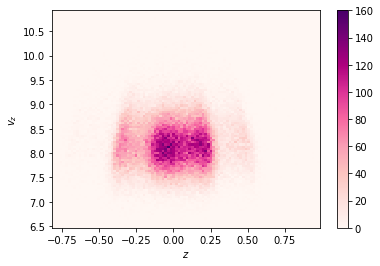

In [5]:
plot_2d_histogram(points[:,1], points[:,2], bins=100)

In [6]:
data = np.loadtxt('U.0500.ascii', unpack=True, skiprows=1)
R = np.sqrt(data[1,:] ** 2 + data[2,:] ** 2)
z = data[3,:]
vz = data[6,:]
vR = (data[1,:] * data[4,:] + data[2,:] * data[5,:]) / R
vp = (data[1,:] * data[5,:] - data[2,:] * data[4,:]) / R
Lz = vp * R
bg_points = np.vstack([z, vz]).T[:200000]

ratio = points.shape[0] / bg_points.shape[0]
# ratio = 'N/A'
print("Spiral2Background Ratio: {}".format(ratio))

Spiral2Background Ratio: 0.50075


In [7]:
points = np.concatenate([points, bg_points])

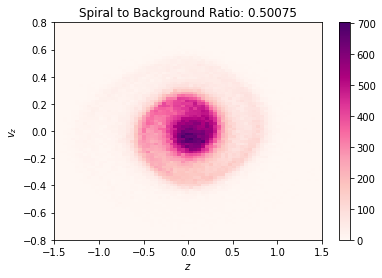

In [8]:
plot_2d_histogram(points[:,0], points[:,1], title="Spiral to Background Ratio: {}".format(ratio))

In [7]:
def NormV(vec):
    norm = np.linalg.norm(vec)
    if (norm == 0):
        return vec
    return vec/norm

#Pass in array H = [[fxx,fxy],[fyx,fyy]]/ Where these are evaluated at some
#position
#VM is a matrix that is meant to convert the MeanShift Vector
#This should be working for any number of dimensions
#Hessian- Matrix evaluated at X.
# m is number of dimensions to remove
def SpectralDecomp(Hessian,m):
    EVal, EVec = np.linalg.eigh(Hessian)
    for i in range(m):
        I = np.argmin(EVal)
        EVec = np.delete(EVec,I,0)
        EVal = np.delete(EVal,I,0)
    V = EVec
    VT = V.T
    VM = np.matmul(VT,V)
    return VM

In [8]:
def deriv3(G):
    G11 = np.gradient(G,axis=0)
    G12 = np.gradient(G,axis=1)
    G13 = np.gradient(G,axis=2)
    G1 = np.array([G11,G12,G13])
    return G1

#Returns the directional derivative, and the Hessian
def gradients3(f):
    #The numeric first derivatives evaluated on same grid as above
    Gx=np.gradient(f,axis = 0)
    Gy=np.gradient(f,axis = 1)
    Gz=np.gradient(f,axis = 2)
    #The second derivatives for the Hessian
    #How should i determine the 65 number?
    s = np.shape(f)
    H = np.empty((3,3,s[0],s[1],s[2]))
    G1 = deriv3(Gx)
    H[0,:,:,:,:] = G1
    G1 = None
    G2 = deriv3(Gy)
    H[1,:,:,:,:] = G2
    G2 = None
    G3 = deriv3(Gz)
    H[2,:,:,:,:] = G3
    G3 = None
    
    return Gx,Gy,Gz,H

#Tri-Linear Interpolation
def Interp3d(Xp,Yp,Zp,gx,gy,gz,F):
    #What to do if at the very edge
    if((Xp < gx[0]) or (Xp>= gx[-1])):
        #print('Out of Bounds')
        return 0
    if((Yp < gy[0]) or (Yp >= gy[-1])):
        return 0
    if((Zp < gz[0]) or (Zp >=gz[-1])):
        return 0
    #Spacing
    dX = gx[1]-gx[0]
    dY = gy[1]-gy[0]
    dZ = gz[1]-gz[0]
    #left index 
    Nx = np.int((Xp-gx[0])/dX)
    Ny = np.int((Yp-gy[0])/dY)
    Nz = np.int((Zp-gz[0])/dZ)
    
    #3D cube has 8 points
    #The x,y weightings
    a = Xp-gx[Nx]
    b = gx[Nx+1]-Xp
    c = Yp-gy[Ny]
    d = gy[Ny+1]-Yp
    #The z weightings
    e1 = Zp-gz[Nz]
    e2 = gz[Nz+1]-Zp
    
    #The back face of the cube
    F111 = F[Nx,Ny,Nz]
    F211 = F[Nx+1,Ny,Nz]
    F121 = F[Nx,Ny+1,Nz]
    F221 = F[Nx+1,Ny+1,Nz]
    #The front face of the cube (Same as above, Nz index shifted by +1)
    F112 = F[Nx,Ny,Nz+1]
    F212 = F[Nx+1,Ny,Nz+1]
    F122 = F[Nx,Ny+1,Nz+1]
    F222 = F[Nx+1,Ny+1,Nz+1]
    
    #Interpolation for back face
    #The linear interpolations in x (Remember, inversely related to distance)
    G = (F111*b+F211*a)/dX
    H = (F121*b+F221*a)/dX
    #The y interpolation
    I = (H*c+G*d)/dY
    
    #Interpolation for front face of cube
    #Same as above for a,b,c,d factors and procedure
    #two x interpolations
    J = (F112*b+F212*a)/dX
    K = (F122*b+F222*a)/dX
    #the y interpolation
    L = (K*c+J*d)/dY
    
    #The z interpolation
    M = (I*e2+L*e1)/dZ
    
    return M

#How to interpolate the Hessian matrix?
def InterpHess3(xi,yi,zi,xe,ye,ze,GHessian):
    size = np.shape(GHessian)
    dim = size[0]
    Hessian = np.zeros([dim,dim])
    for i in range(dim):
        for j in range(dim):
            Gij = GHessian[i,j]
            Gijp = Interp3d(xi,yi,zi,xe,ye,ze,Gij)
            Hessian[i,j] = Gijp
    return Hessian 

def meanShift_3D(Xp,Yp,Zp,gx,gy,gz,Gx,Gy,Gz,GH,m):
    Px = Interp3d(Xp,Yp,Zp,gx,gy,gz,Gx)
    Py = Interp3d(Xp,Yp,Zp,gx,gy,gz,Gy)
    Pz = Interp3d(Xp,Yp,Zp,gx,gy,gz,Gz)
    MS = np.array([Px,Py,Pz])
    MS = NormV(MS)
    #Hessian Calculations
    Hessian = InterpHess3(Xp,Yp,Zp,gx,gy,gz,GH)
    #Change m to 2 or 1 or 0 see what happens
    VM = SpectralDecomp(Hessian,m)
    MC = np.matmul(VM,MS)
    MC = NormV(MC)
    return MC

#Using Cash-Karp Parameters for Embedded Runge-Kutta Method
def RFA_EmbeddedRK_3D(Xp,Yp,Zp,Gx,Gy,Gz,GH,gx,gy,gz,dh,m):
    #First Step
    MC = meanShift_3D(Xp,Yp,Zp,gx,gy,gz,Gx,Gy,Gz,GH,m)
    k1 = dh*MC
    #Step 2
    P = np.array([Xp,Yp,Zp])
    Pt = P+k1/5
    MC = meanShift_3D(Pt[0],Pt[1],Pt[2],gx,gy,gz,Gx,Gy,Gz,GH,m)
    k2 = dh*MC
    #Step 3
    Pt = P+k1*3./40+k2*9./40
    MC = meanShift_3D(Pt[0],Pt[1],Pt[2],gx,gy,gz,Gx,Gy,Gz,GH,m)
    k3 = dh*MC
    #Step 4
    Pt = P+k1*3./10+k2*(-9./10)+k3*6./5
    MC = meanShift_3D(Pt[0],Pt[1],Pt[2],gx,gy,gz,Gx,Gy,Gz,GH,m)
    k4 = dh*MC
    #Step 5
    Pt = P+k1*(-11./54)+k2*5./2+k3*(-70./27)+k4*35./27
    MC = meanShift_3D(Pt[0],Pt[1],Pt[2],gx,gy,gz,Gx,Gy,Gz,GH,m)
    k5 = dh*MC
    #Step 6
    Pt = P+k1*(1631./55296)+k2*(175./512)+k3*(575./13824)+k4*(44275./110592)+k5*(253./4096)
    MC = meanShift_3D(Pt[0],Pt[1],Pt[2],gx,gy,gz,Gx,Gy,Gz,GH,m)
    k6 = dh*MC
    
    #Fifth-order Runge-Kutta Formula
    Pn2 = P+k1*37./378+k3*250./621+k4*125./594+k6*512./1771
    
    #Embedded fourth-order Runge-Kutta formula
    Pn1 = P+k1*2825./27648+k3*18575./48384+k4*13525./55296+k5*277./14336+k6*1./4
    
    return Pn1[0],Pn1[1],Pn1[2],Pn2[0],Pn2[1],Pn2[2]

def RFA_AdaptiveStep_Lin_ERK_3D(dataset,f,gx,gy,gz,tcap,m):
    size = np.shape(dataset)
    #Each point starts with a default step size
    H = np.zeros(size[1])+0.0025
    Xn = dataset[0,:]
    Yn = dataset[1,:]
    Zn = dataset[2,:]
    
    print('Shallow Copy Complete')
    #The accuracy tolerance
    dx0 = 0.00005
    dy0 = 0.00005
    dz0 = 0.00005
    Gx,Gy,Gz,GH = gradients3(f)
    collected = gc.collect()
    print("Collected at Gradient Calculation %d" % collected)
    
    for t in range(tcap):
        count = 0
        for i in range(size[1]):
            Xp = Xn[i]
            Yp = Yn[i]
            Zp = Zn[i]
            if(ma.is_masked(Xp) or ma.is_masked(Yp) or ma.is_masked(Zp)):
                continue
            if(abs(Xp) >= 100.):
                continue
            if(abs(Yp) >= 100):
                continue
            if(abs(Zp) >= 100):
                continue
            h = H[i] #Each point has its own error
            if(h < 0.005/100):
                continue
                #If h becomes 100 times smaller just skip it
            #Embedded Runge-Kutta
            x1,y1,z1,x2,y2,z2 = RFA_EmbeddedRK_3D(Xp,Yp,Zp,Gx,Gy,Gz,GH,gx,gy,gz,h,m)
            dx1 = abs(x2-x1)
            if(dx1 == 0):
                modx = 2
            else:
                modx = (dx0/dx1)**(0.2)
                if(modx > 2):
                    modx = 2
            dy1 = abs(y2-y1)
            if(dy1 ==0):
                mody = 2
            else:
                mody = (dy0/dy1)**(0.2)
                if(mody > 2):
                    mody = 2
            dz1 = abs(z2-z1)
            if(dz1 ==0):
                modz = 2
            else:
                modz = (dz0/dz1)**(0.2)
                if(modz > 2):
                    modz = 2
            #Choose the smaller mod value
            mods = np.array([modx,mody,modz])
            mod  = min(mods)
            if(mod < 1): #d1 > d0, we have to retry! with new step
                count = count+1
                h = h*mod
                x1,y1,z1,x2,y2,z2 = RFA_EmbeddedRK_3D(Xp,Yp,Zp,Gx,Gy,Gz,GH,gx,gy,gz,h,m)
                H[i] = h #update the new h value
                Xn[i] = x2
                Yn[i] = y2
                Zn[i] = z2
            else: #We can safely increase the next step size
                H[i] = h*mod
                Xn[i] = x2 #the small step we already calculated was good enough
                Yn[i] = y2 
                Zn[i] = z2
        print("At iteration {:d}, fraction: {:.3f}".format(t,count/size[1]))
    return Xn,Yn,Zn,H

In [42]:
myPDF,axes = fastKDE.pdf(points[:,0],points[:,1],points[:,2])

# d = 2
# A0 = 1
# bw = A0 * min(np.std(points[:,0]), np.std(points[:,1])) * 1 / (
#     d + 2) ** (1 / (d + 4)) / points.shape[0] ** (1 / (d + 4))
# print("BW =", bw)
# bound = 256 * bw / 2
# v1, v2 = np.linspace(-bound,bound,256), np.linspace(-bound,bound,256)
# myPDF = kde.kde2(points, v1, v2, bandwidth=bw).T
myPDF = myPDF.swapaxes(0,2)

114018


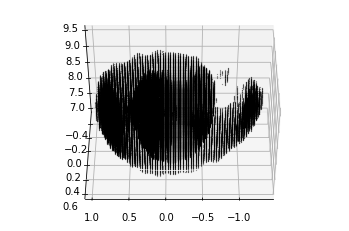

In [43]:
v1,v2,v3 = axes
tmpindx1 = np.where((2.5>v1) & (-2.5<v1))
v1 = v1[tmpindx1]
myPDF = myPDF[tmpindx1,:,:][-1]
tmpindx2 = np.where((1.5>v2) & (-1.5<v2))
v2 = v2[tmpindx2]
myPDF = myPDF[:,tmpindx2[0],:]
# tmpindx3 = np.where((8.9>v3) & (6.1<v3))
# v3 = v3[tmpindx3]
# myPDF = myPDF[:,:,tmpindx3[0]]

zg,wg,jpg = np.meshgrid(v1,v2,v3,indexing='ij')
zg_ma = ma.masked_where(myPDF < np.std(myPDF),zg)
zg = None
wg_ma = ma.masked_where(myPDF < np.std(myPDF),wg)
wg = None
jpg_ma = ma.masked_where(myPDF < np.std(myPDF),jpg)
T = zg_ma.compressed()
newS = len(T)
print(newS)
P1_ma = ma.zeros((3,newS))
P1_ma[0,:] = zg_ma.compressed()
P1_ma[1,:] = wg_ma.compressed()
P1_ma[2,:] = jpg_ma.compressed()
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.view_init(45,90)
ax.plot(P1_ma[0,:],P1_ma[1,:],P1_ma[2,:],'k.',markersize=0.3)
plt.show()

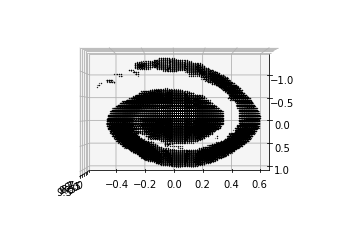

In [45]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.view_init(90,0)
ax.plot(P1_ma[0,:],P1_ma[1,:],P1_ma[2,:],'k.',markersize=0.3)
plt.show()

In [46]:
X1,Y1,Z1,H1 = RFA_AdaptiveStep_Lin_ERK_3D(P1_ma,myPDF,v1,v2,v3,20,1)

Shallow Copy Complete
Collected at Gradient Calculation 9006
At iteration 0, fraction: 0.024
At iteration 1, fraction: 0.090
At iteration 2, fraction: 0.207
At iteration 3, fraction: 0.356
At iteration 4, fraction: 0.479
At iteration 5, fraction: 0.524
At iteration 6, fraction: 0.560
At iteration 7, fraction: 0.591
At iteration 8, fraction: 0.626
At iteration 9, fraction: 0.660
At iteration 10, fraction: 0.694
At iteration 11, fraction: 0.719
At iteration 12, fraction: 0.743
At iteration 13, fraction: 0.768
At iteration 14, fraction: 0.782
At iteration 15, fraction: 0.795
At iteration 16, fraction: 0.803
At iteration 17, fraction: 0.810
At iteration 18, fraction: 0.813
At iteration 19, fraction: 0.816


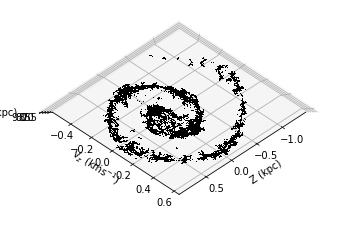

In [59]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.plot(X1,Y1,Z1,'k,',markersize=0.1)
ax.view_init(90, 45)
ax.set_xlabel('\nZ (kpc)')
ax.set_ylabel('\nV$_z$ (kms$^{-1}$)\n')
ax.set_zlabel('R (kpc)')
fig.savefig('res_3d.png', dpi=300, bbox_inches='tight', pad_inches=0.3)
fig.show()